# Convergence Test 
Only trust those don't change under different resolutions.

In [1]:
import numpy as np
from nozzle import Spectral, Params, Nozzle, Boundary
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import simpson
from scipy.interpolate import BSpline

## Finite-Difference

In [18]:
Mm = 0.5
constant_v = False
accelerating = False
boundary = Boundary.FIXED_OPEN
Delta_range = [1, 2,3,4,5]
# N_range = range(101, 802, 100)

experiments = []
for Delta in tqdm(Delta_range):
    params = Params(Mm, constant_v, accelerating, boundary, Delta=Delta)
    spectral = Spectral(501, "symmetric", "FD")
    nozzle = Nozzle(params, spectral.x)
    v0 = nozzle.v0
    x = spectral.x
    dx = x[1] - x[0]
    D1 = spectral.D1
    D2 = spectral.D2
    D1v = D1.copy()
    D2v = D2.copy()
    D1v[-2,:] = 0
    D1v[-2,-3:-1] = np.array([-4/3, 4/3])/(2*dx)
    D2v[-2,:] = 0
    D2v[-2,-3:-1] = np.array([2/3, -2/3])/dx**2

    A11 = np.zeros_like(D1)
    A12 = np.eye(*D1.shape)
    A21 = -np.diag(1-v0**2)@D2v \
            + np.diag((3*v0 + 1/v0)*(D1@v0))@D1v \
            + np.diag((1-1/v0**2)*(D1@v0)**2) \
            + np.diag((v0+1/v0)*(D2@v0))
    A22 = -2j*(np.diag(v0)@D1v + np.diag(D1@v0))

    A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
    V, nozzle.omega = nozzle.solve(A)
    V = np.pad(V, ((1,1),(0,0))) # pad two ends by 0
    V[-1,:] = (4*V[-2,:] - V[-3,:])/3 # modify the last row
    nozzle.V = V
    nozzle.sort_solutions(real_range=[-0.1, 50], imag_range=[-1,1])
    experiments.append(nozzle)

100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


Text(54.097222222222214, 0.5, 'v_exact')

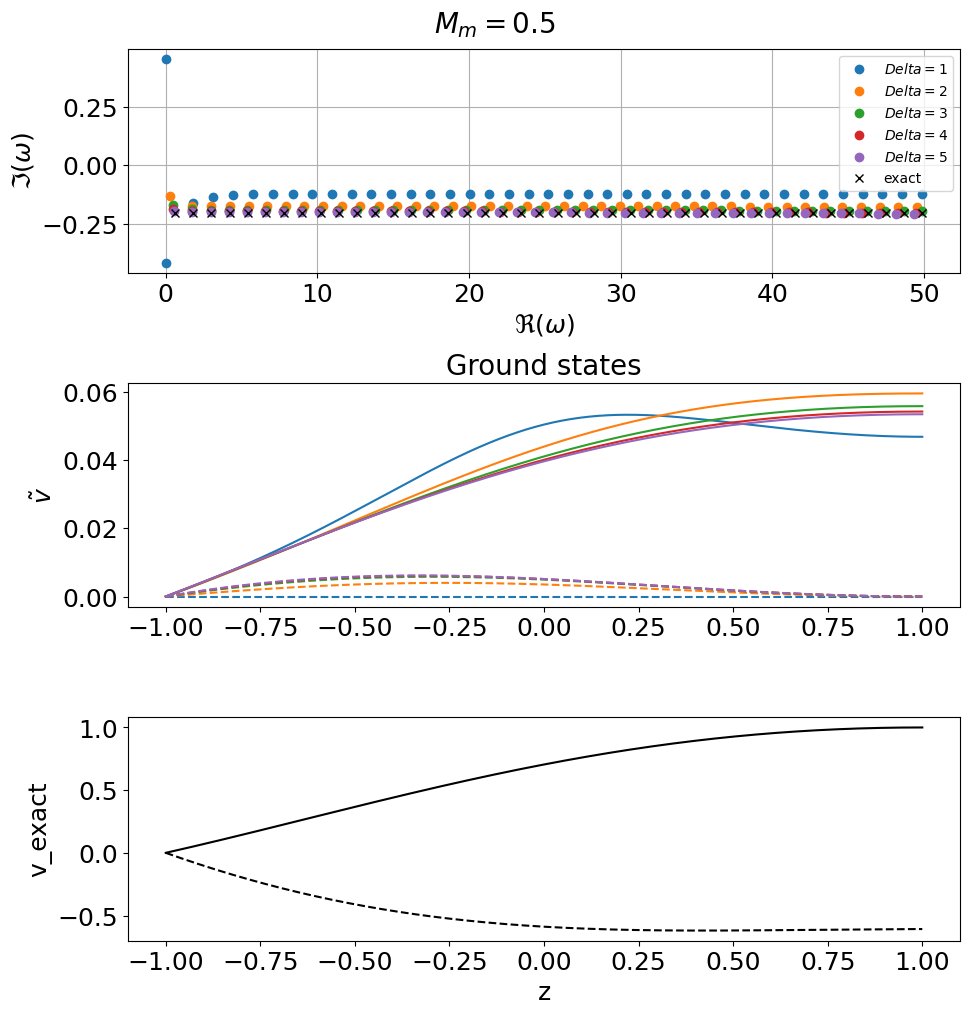

In [21]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
for exp in experiments:
    exp.plot_eigenvalues(ax=ax[0])
    v = exp.V[:,0]
    v_sqr = np.abs(v)**2
    line = ax[1].plot(exp.x, v.real)
    ax[1].plot(exp.x, v.imag, '--', color=line[-1].get_color())
ax[0].legend([f"$Delta=${Delta}" for Delta in Delta_range], fontsize="medium", bbox_to_anchor=(1,1))
ax[0].grid()
ax[1].set_ylabel("$\\tilde{v}$")
ax[1].set_title("Ground states")
fig.suptitle(f"$M_m=${Mm}")
fig.tight_layout()

# exact eigenvalues
n = np.arange(exp.omega.size) 
v0 = nozzle.v0[0]
omega = (v0**2-1)*(2*n*np.pi - 1j*np.log((v0-1)/(v0+1)+0j))/4
# omega.real = np.abs(omega.real)
ax[0].plot(-omega.real, omega.imag, "kx")
ax[0].legend([f"$Delta=${Delta}" for Delta in Delta_range] + ["exact"], fontsize="medium", bbox_to_anchor=(1,1))

z = nozzle.x
v = np.exp(-1j*omega[0]/(v0+1)) * ( np.exp(1j*omega[0]*(z+1)/(v0+1)) - np.exp(1j*omega[0]*(z+1)/(v0-1)))
v_sqr = np.abs(v)**2
ax[2].plot(z,v.real/np.abs(v.real).max(),"k")
ax[2].plot(z,v.imag,"k--")
ax[2].set_xlabel("z")
ax[2].set_ylabel("v_exact")

## Finite-Element

In [79]:
# M = 501 # number of points
k = 2 # degree of b-spline
N = 101 # number of basis function

Mm = 1.5
constant_v = False
accelerating = False
boundary = Boundary.FIXED_OPEN
params = Params(Mm, constant_v, accelerating, boundary)

M_range = range(101,702,100)
experiments = []
for M in tqdm(M_range):
    t = np.concatenate([-np.ones(k), np.linspace(-1,1,N-k+1) ,np.ones(k)]) # knot vector
    u = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k)(x) # basis functions
    u_p = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative()(x) # basis functions
    u_pp = lambda x,n: BSpline(t,np.eye(t.size-k-1)[n],k).derivative(2)(x) # basis functions

    spectral = Spectral(M, "symmetric", "FD")
    x = spectral.x
    D1 = spectral.D1
    D2 = spectral.D2

    nozzle = Nozzle(params, x, lambda x,n: u(x,n))
    v0 = nozzle.v0

    A2 = np.zeros((N-1,N-1), dtype=complex) # n from -1 to N+1
    A1 = np.zeros((N-1,N-1), dtype=complex)
    A0 = np.zeros((N-1,N-1), dtype=complex)
    for i in range(N-1):
        for j in range(N-1):
            if np.abs(i-j) <= 3:
                A2[i,j] = simpson(u(x,i)*u(x,j),x)
                A1[i,j] = 2j*simpson(u(x,i)*v0*u_p(x,j) + u(x,i)*(D1@v0)*u(x,j),x)
                A0[i,j] = simpson(
                    u(x,i)*(1-v0**2)*u_pp(x,j) -
                    u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,j) - 
                    u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
                    u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
                    x)

                # open right end condition
                A2[i,j] -= u_p(1,j)/u_p(1,N-1)*simpson(u(x,i)*u(x,N-1),x)
                A1[i,j] -= 2j*u_p(1,j)/u_p(1,N-1)*simpson(u(x,i)*(v0*u_p(x,N-1)+(D1@v0)*u(x,N-1)),x)
                A0[i,j] -= u_p(1,j)/u_p(1,N-1)*simpson(
                        u(x,i)*(1-v0**2)*u_pp(x,N-1) -
                        u(x,i)*(3*v0+1/v0)*(D1@v0)*u_p(x,N-1) - 
                        u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,N-1) -
                        u(x,i)*(v0+1/v0)*(D2@v0)*u(x,N-1),
                        x)

    C, nozzle.omega = nozzle.polyeig(A0[1:,1:],A1[1:,1:],A2[1:,1:])
    C = np.pad(C, ((1,0),(0,0)))
    nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
    for i in range(C.shape[1]):
        for n in range(N):
            if (n<N-1):
                nozzle.V[:,i] += C[n,i]*u(x, n)
            else:
                c_last = -np.sum([C[k,i]*u_p(1,k) for k in range(N-1)])/u_p(1,N-1)
                nozzle.V[:,i] += c_last*u(x, N-1)
    nozzle.sort_solutions(real_range=[0,7], imag_range=[-1,1])
    experiments.append(nozzle)

100%|██████████| 7/7 [01:06<00:00,  9.43s/it]


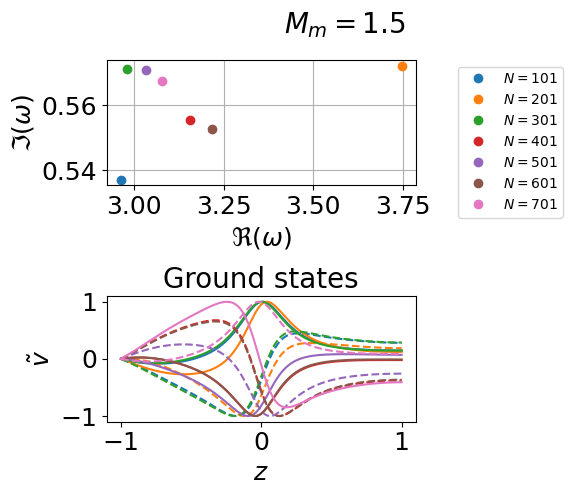

In [84]:
fig, ax = plt.subplots(2,1,figsize=(7,5))
for exp in experiments:
    exp.plot_eigenvalues(ax=ax[0])
    exp.plot_eigenfunctions(num_funcs=1, ax=ax[1])
ax[0].legend([f"$N=${N}" for N in N_range], fontsize="medium", bbox_to_anchor=(1.5,1))
ax[0].grid()
ax[1].legend().remove()
ax[1].set_title("Ground states")
fig.suptitle(f"$M_m=${Mm}")
fig.tight_layout()

# exact eigenvalues
# n = np.arange(exp.omega.size) 
# v0 = nozzle.v0[0]
# omega = (v0**2-1)*(2*n*np.pi - 1j*np.log((v0-1)/(v0+1)+0j))/4
# omega.real = np.abs(omega.real)
# ax[0].plot(omega.real, omega.imag, "kx")
# ax[0].legend([f"$N=${N}" for N in N_range] + ["exact"], fontsize="medium", bbox_to_anchor=(1,1))

# z = nozzle.x
# v = np.exp(-1j*omega[0]/(v0+1)) * ( np.exp(1j*omega[0]*(z+1)/(v0+1)) - np.exp(1j*omega[0]*(z+1)/(v0-1)))
# ax[1].plot(z,v.real/np.abs(v.real).max(),"k")
# ax[1].plot(z,v.imag,"k--")